In [1]:
##Preable
from __future__ import division
import numpy as np
import pandas as pd
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy
import pickle
import emcee
import corner
import wandb

from EightBitTransit.cTransitingImage import TransitingImage
from EightBitTransit.inversion import *
from EightBitTransit.misc import *

%matplotlib inline

In [2]:
def fillShape(grid, shapes):
    """Creates a grid with the shape bound by given points filled in.
    Points in the sublists are connected in the order they are given
    Sublists are not connected to each other

    Args:
        grid (list) - list of grid coordinates as tuples
        shapes (list) - list of shapes, each entry is a collection of points
            defining the vertices of a polygon

    Returns:
    """
    # Create a grid to plot the outline on
    # need a binary image to simulate transits
    grid_df = pd.DataFrame(data=grid, columns=['x', 'y'])  # df is easier to work with
    grid_shape = [grid_df.x.max(), grid_df.y.max()]
    outline = np.zeros(grid_shape) 

    for shape in shapes:
        points_df = pd.DataFrame(data=shape, columns=['x', 'y'])
        polygon = Polygon(points_df)
        test_inside_mask = polygon.contains_points(grid)
        outline[grid_df[test_inside_mask].x, grid_df[test_inside_mask].y] = 1

    return outline

In [3]:
def generatePoints(n, xdim, ydim,xoffset = 0,yoffset = 0,rotation = 0): ##Generates points of a regular polygon with n edges, radius of r*size
    ##Size is grid size, 0 < r < 0.5, rotation rotates the shape from having a point vertically down
    points = []
    for i in range(n):
        y = int(ydim*np.cos(i*2*np.pi/n + np.pi/n))
        x = int(xdim*np.sin(i*2*np.pi/n + np.pi/n))
        nuy = int(x*np.sin(rotation)+y*np.cos(rotation) + yoffset)
        nux = int(x*np.cos(rotation)-y*np.sin(rotation) + xoffset)
        points.append([nuy,nux])
    return points

In [4]:
def getData(filename): ##Gets the time array from the TESS Light Curve
    fp = open("./"+filename+".pkl","rb") ##Loading the file
    data = pickle.load(fp)
    fp.close()
    
    q = data[11]==0
    times = data[6][q]
    flux = data[9][q]
    maxFlux = np.median(flux)
    flux /= maxFlux
    err = np.ones_like(flux)*np.nanstd(np.diff(flux))
    err /= np.sqrt(2)
    return times, flux, err

In [5]:
def extendLC(LC, overlapTimes, times):
    extendedLC = np.ones(len(times))##Start with full flux curve
    overlapIndex = 0
    if len(overlapTimes) > 0:
        for i in range(len(times)):##Iterate over the desired time array
            if times[i] == overlapTimes[overlapIndex]: ##When the desired time has caught up to the light curve from ebt, use the ebt values
                if overlapIndex < len(overlapTimes) - 2:##Only do this to the end of the ebt light curve
                    overlapIndex += 1
                    extendedLC[i]  = LC[overlapIndex]
        
    return extendedLC, times

In [92]:
def model(sides,xdim,ydim,rotation,velocity, tRef, times):
    points = generatePoints(sides,xdim,ydim,xdim + 2,50,rotation)
    pointsList = [points]
    grid = []
    for i in range(100):
        for j in range(int(2*np.max((xdim,ydim))+4)):
            grid.append((i,j))
    planetGrid = fillShape(grid,pointsList)
    planet = TransitingImage(opacitymat = planetGrid, v = velocity, t_ref = tRef, t_arr = times)
    planetLC, overlapTimes = planet.gen_LC(t_arr = times)
    planetLC, times = extendLC(planetLC, overlapTimes, times)
    return planetLC

In [8]:
def logLikelihood(theta, times, flux, fluxErr):
    sides, xdim, ydim, rotation, velocity, tRef = theta
    fluxPredicted = model(int(sides),xdim, ydim,rotation,velocity,tRef,times)
    lnl = -np.sum(((flux - fluxPredicted)**2) /(2*fluxErr**2))
    return lnl

In [9]:
def logPrior(theta, times):
    sides, xdim, ydim, rotation, velocity, tRef = theta
    lnPrior = 0
    if times[0] < tRef < times[-1]:
        lnPrior += np.log(1/(times[-1]-times[0]))
    else:
        return -np.inf
    if  -np.pi  <= rotation < 3*np.pi:
        lnPrior += np.log(1/(2*np.pi))
    else:
        return -np.inf
    if 3 <= sides < 24 and 0 < xdim < 100 and 0 < ydim < 100 and 0 < velocity < 50:
        lnPrior +=  2*np.log(1/100) + np.log(1/50) ##Sides removed
    else:
        return -np.inf
    return lnPrior

In [10]:
def logProbability(theta, times, flux, fluxErr):
    lp = logPrior(theta, times)
    if not np.isfinite(lp):
        return -np.inf
    ll = logLikelihood(theta, times, flux, fluxErr)
    return lp + ll

In [63]:
times, flux, fluxErr = getData("tesslc_1420332000000")
theta0 = [4, 4.5, 11, 0, 2, 1558]
print(logProbability(theta0,times, flux, fluxErr))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


-1253.343899655803


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # 

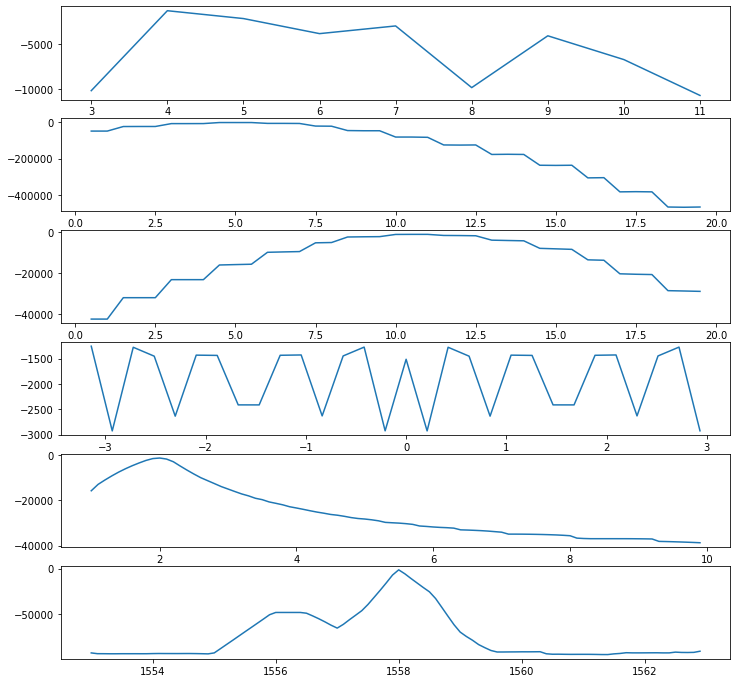

In [93]:
fig, ax = plt.subplots(6,1, figsize = (12,12))
logProb = []
offset = []
offset.append(np.arange(3,12))
offset.append(np.arange(0,20,0.5))
offset.append(np.arange(0,20,0.5))
offset.append(np.arange(-np.pi,np.pi,np.pi/15))
offset.append(np.arange(1,10,0.1))
offset.append(np.arange(1553,1563,0.1))
for i in range(6):
    logProb.append([])
    theta0 = [4, 4.5, 11, 0, 2, 1558]
    for j in offset[i]:
        theta0[i] = j
        logProb[i].append(logProbability(theta0, times, flux, fluxErr))
    ax[i].plot(offset[i],logProb[i])
    
plt.show()
    


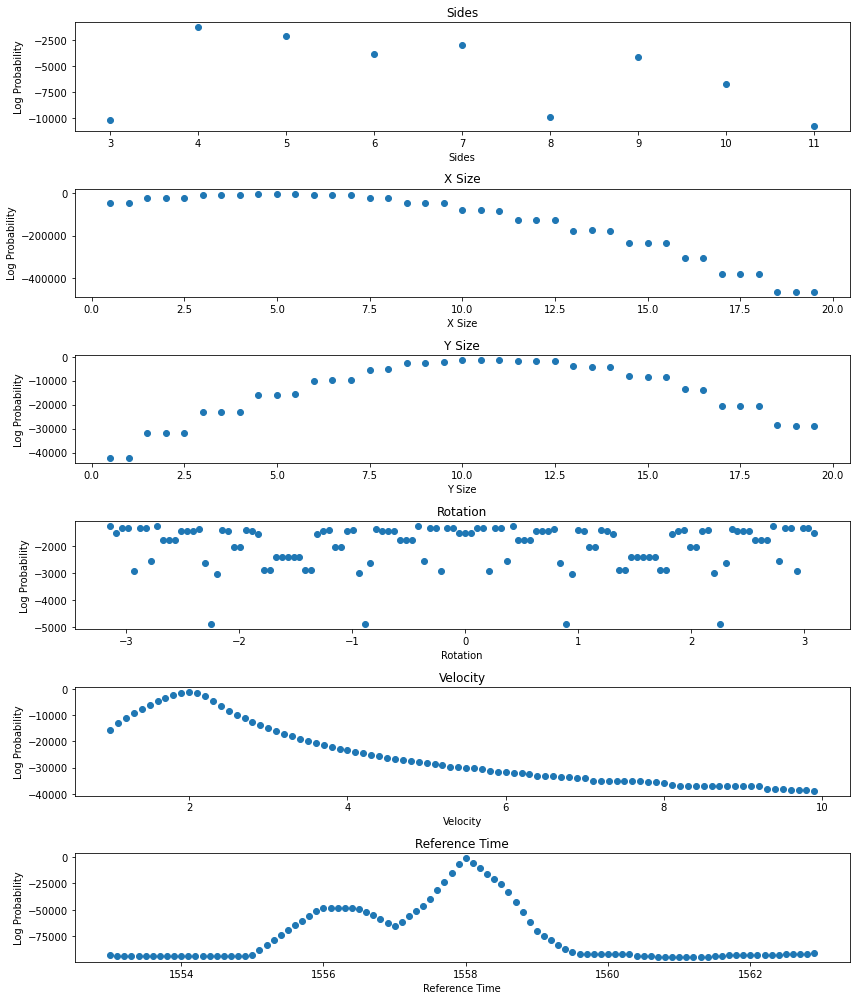

In [65]:
fig, ax = plt.subplots(6,1, figsize = (12,14))
parameters = ["Sides","X Size", "Y Size","Rotation","Velocity","Reference Time"]
for i in range(6):
    ax[i].plot(offset[i],logProb[i], 'o')
    ax[i].set_ylabel("Log Probability")
    ax[i].set_xlabel(parameters[i])
    ax[i].set_title(parameters[i])
fig.tight_layout()
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


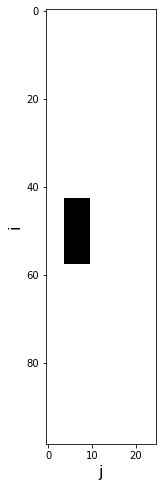

In [89]:
planetLC = model(4,4.5,11,0,2,1558,times)

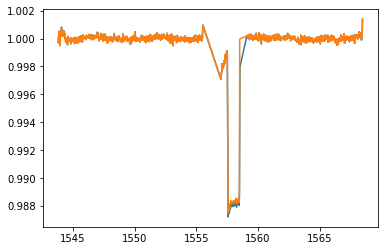

In [90]:
trueTimes, trueFlux, trueFluxErr = getData("tesslc_364539361")
trueFlux /= np.max(trueFlux)
newLC = planetLC + trueFlux -1
newLC /= np.median(newLC)
diffLC = flux - newLC
plt.plot(times, flux)
plt.plot(times, newLC)